# CutQC Tutorial 2: Circuit Cutting with Manual Wire Cutting

**NOTE: CutQC is deprecated and will be removed no sooner than Circuit Knitting Toolbox v0.8.0.  The circuit cutting workflow in `circuit_knitting.cutting` now implements similar and improved functionalities, which will be maintained going forward.**

Circuit cutting is a technique to decompose a quantum circuit into smaller circuits, whose results can be knitted together to reconstruct the original circuit output. 

The circuit knitting toolbox implements a wire cutting method presented in [CutQC](https://doi.org/10.1145/3445814.3446758) (Tang et al.). This method allows a circuit wire to be cut such that the generated subcircuits are amended by measurements in the Pauli bases and by state preparation of four Pauli eigenstates (see Fig. 4 of [CutQC](https://doi.org/10.1145/3445814.3446758)).

This wire cutting technique is comprised of the following basic steps:

1. **Decompose**: Cut a circuit into multiple subcircuits. Here, we'll use a manual method to specify the cut(s). See [tutorial 1](tutorial_1_automatic_cut_finding.ipynb) to automatically cut a circuit.
2. **Evaluate**: Execute those subcircuits on quantum backend(s).
3. **Reconstruct**: Knit the subcircuit results together to reconstruct the original circuit output (in this case, the full probability distribution).

## Create a quantum circuit with Qiskit

In this tutorial, we'll use the example circuit shown in [CutQC](https://dl.acm.org/doi/10.1145/3445814.3446758).

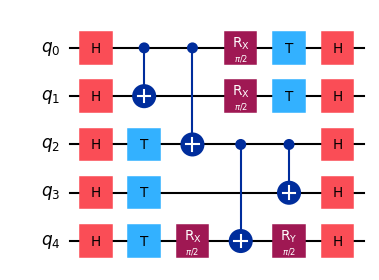

In [1]:
import numpy as np
from qiskit import QuantumCircuit

num_qubits = 5

circuit = QuantumCircuit(num_qubits)
for i in range(num_qubits):
    circuit.h(i)
circuit.cx(0, 1)
for i in range(2, num_qubits):
    circuit.t(i)
circuit.cx(0, 2)
circuit.rx(np.pi / 2, 4)
circuit.rx(np.pi / 2, 0)
circuit.rx(np.pi / 2, 1)
circuit.cx(2, 4)
circuit.t(0)
circuit.t(1)
circuit.cx(2, 3)
circuit.ry(np.pi / 2, 4)
for i in range(num_qubits):
    circuit.h(i)

circuit.draw("mpl", fold=-1, scale=0.75)

## Decompose the circuit with wire cutting

In this example, we will use a manual method to specify the wire cuts. See [tutorial 1](tutorial_1_automatic_cut_finding.ipynb) for how to automatically cut a circuit. The figure below shows the steps for producing the `subcircuit_vertices` argument for the `cut_circuit_wires` function.

   * `method='manual'`: Manually specify the wire cuts
   * `subcircuit_vertices`: A list of lists containing the two-qubit gate indices appearing on either side of the cut(s)
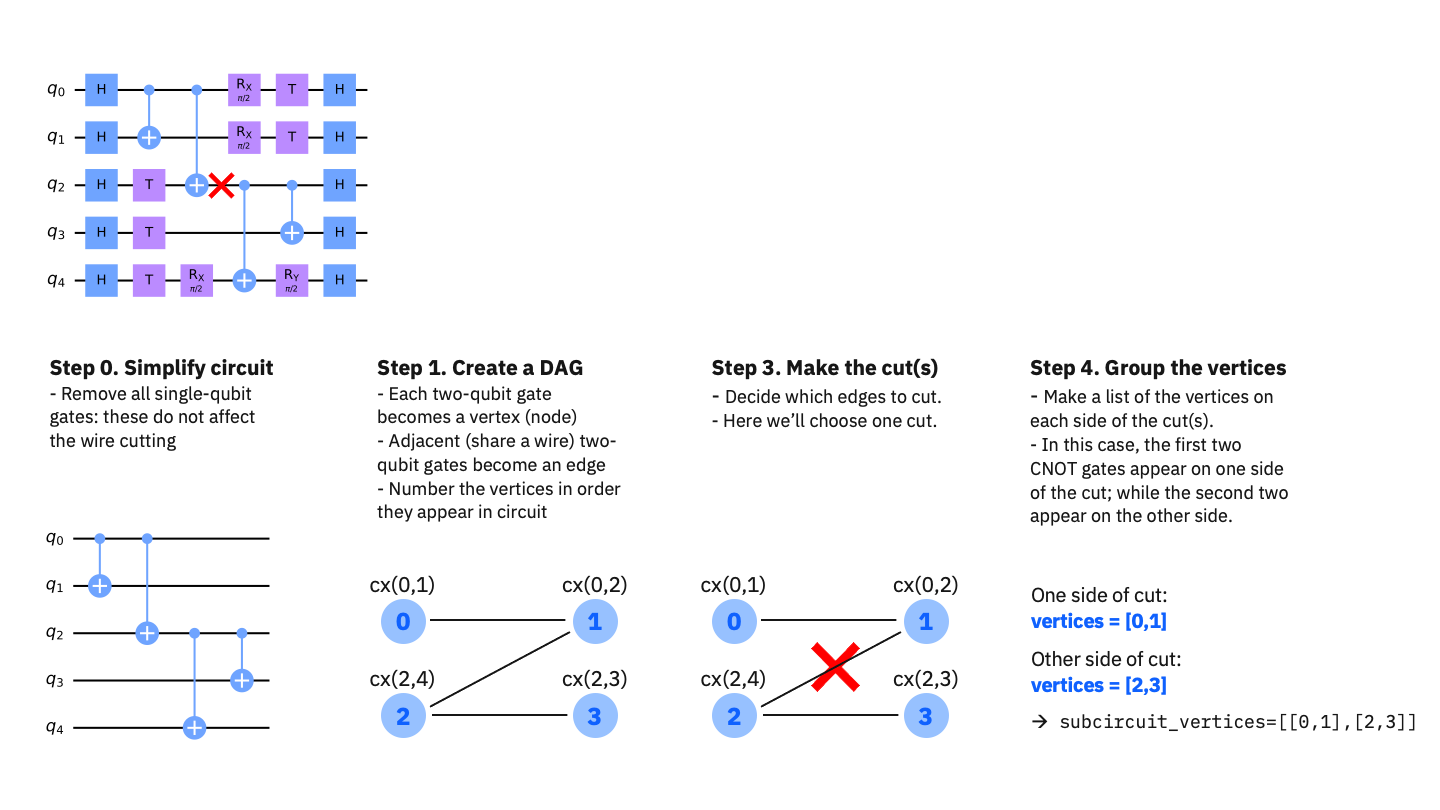

In [2]:
%%capture

from circuit_knitting.cutting.cutqc import cut_circuit_wires

cuts = cut_circuit_wires(
    circuit=circuit, method="manual", subcircuit_vertices=[[0, 1], [2, 3]]
)

**The two subcircuits produced**

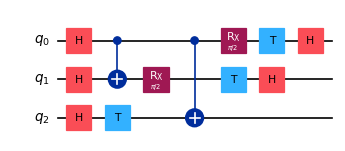

In [3]:
# visualize the first subcircuit
cuts["subcircuits"][0].draw("mpl", fold=-1, scale=0.6)

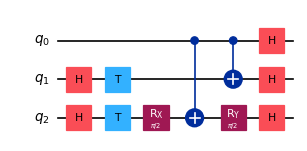

In [4]:
# visualize the second subcircuit
cuts["subcircuits"][1].draw("mpl", fold=-1, scale=0.6)

## Evaluate the subcircuits

**Set up the Qiskit Runtime Service**

The Qiskit Runtime Service provides access to Qiskit Runtime Primitives and quantum backends. See the [Qiskit Runtime documentation](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/) for more information.
Alternatively, if a Qiskit Runtime Service is not passed, then a local statevector simulator will be used with the [Qiskit Primitives](https://docs.quantum.ibm.com/api/qiskit/primitives).

In [5]:
from qiskit_ibm_runtime import (
    QiskitRuntimeService,  # noqa: F401
    Options,
)

# Use local versions of the primitives by default.
service = None

# Uncomment the following line to instead use Qiskit Runtime Service.
# service = QiskitRuntimeService()

**Configure the Qiskit Runtime Primitive**

The wire cutter tool uses a `Sampler` primitive to evaluate the probabilities of each subcircuit. Here, we configure the options for the Qiskit Runtime Sampler and specify the backend(s) to be used to evaluate the subcircuits. Backends could be [simulator(s) and/or quantum device(s)](https://quantum-computing.ibm.com/services/resources?tab=systems). In this tutorial, two local cores will be used to support each of the parallel backend threads we'll specify below.

If no service was set up, the `backend_names` argument will be ignored, and Qiskit Primitives will be used with statevector simulator.

In [6]:
# Set the Sampler and runtime options
options = Options(execution={"shots": 4000})

# Use the least busy backend for both threads
backend_names = None
if service is not None:
    backend_names = [service.least_busy().name] * 2

**Evaluate the subcircuits on the backend(s)**

In [7]:
from circuit_knitting.cutting.cutqc import evaluate_subcircuits

subcircuit_instance_probabilities = evaluate_subcircuits(cuts)

# Uncomment the following lines to instead use Qiskit Runtime Service as configured above.
# subcircuit_instance_probabilities = evaluate_subcircuits(cuts,
#                                                          service=service,
#                                                          backend_names=backend_names,
#                                                          options=options,
#                                                         )

/tmp/ipykernel_3051/4196057829.py:3: DeprecationWarning: The function ``circuit_knitting.cutting.cutqc.wire_cutting.evaluate_subcircuits()`` is deprecated as of circuit-knitting-toolbox 0.7.0. It will be removed no sooner than CKT v0.8.0. Use the wire cutting or automated cut-finding functionality in the ``circuit_knitting.cutting`` package. 
  subcircuit_instance_probabilities = evaluate_subcircuits(cuts)


 **See Tutorial 1 for more info about the subcircuit results.**

## Reconstruct the full circuit output

Next, the results of the subcircuit experiments are classically postprocessed to reconstruct the original circuit's full probability distribution.

In [8]:
%%capture

from circuit_knitting.cutting.cutqc import (
    reconstruct_full_distribution,
)

reconstructed_probabilities = reconstruct_full_distribution(
    circuit, subcircuit_instance_probabilities, cuts
)

## Verify the results

If the original circuit is small enough, we can use a statevector simulator to check the results of cutting against the original circuit's exact probability distribution (ground truth).

In [9]:
from circuit_knitting.cutting.cutqc import verify

metrics, exact_probabilities = verify(circuit, reconstructed_probabilities)

/tmp/ipykernel_3051/3419935587.py:3: DeprecationWarning: The function ``circuit_knitting.cutting.cutqc.wire_cutting_verification.verify()`` is deprecated as of circuit-knitting-toolbox 0.7.0. It will be removed no sooner than CKT v0.8.0. Use the wire cutting or automated cut-finding functionality in the ``circuit_knitting.cutting`` package. 
  metrics, exact_probabilities = verify(circuit, reconstructed_probabilities)


**The verify step includes several metrics**

For example, the chi square loss is computed. Since we're using the Qiskit Sampler with statevector simulator, we expect the reconstructed distributed to exactly match the ground truth. More info about each metric can be found in the [utils metrics file](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/blob/main/circuit_knitting/utils/metrics.py).

In [10]:
metrics

{'nearest': {'chi2': 0,
  'Mean Squared Error': 2.2429332936235563e-32,
  'Mean Absolute Percentage Error': 1.1722866042107947e-13,
  'Cross Entropy': 2.599681088367844,
  'HOP': 0.9004283905932716},
 'naive': {'chi2': 0,
  'Mean Squared Error': 2.033924079765218e-33,
  'Mean Absolute Percentage Error': 1.212151701573308e-13,
  'Cross Entropy': 2.5996810883678423,
  'HOP': 0.9004283905932735}}

**Visualize both distributions**

If we calculated the ground truth above, we can visualize a comparison to the reconstructed probabilities

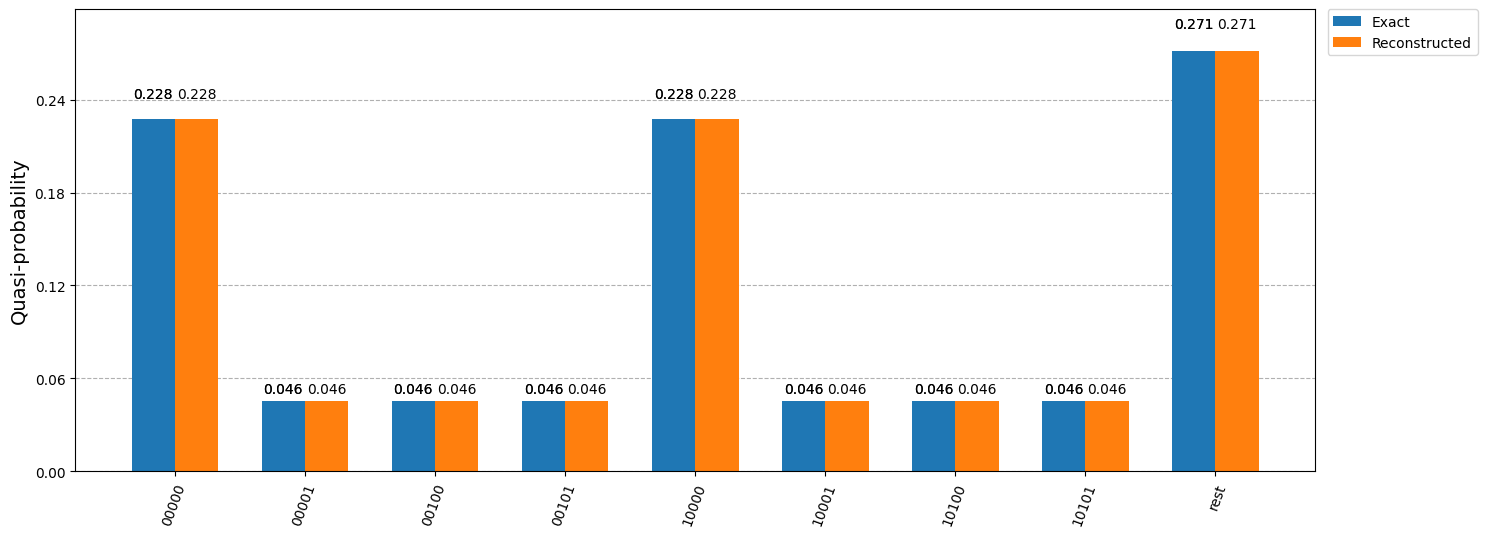

In [11]:
from qiskit.visualization import plot_histogram
from qiskit.result import ProbDistribution

# Create a dict for the reconstructed distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Represent states as bitstrings (instead of ints)
reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)


# Create the ground truth distribution dict
exact_distribution = {i: prob for i, prob in enumerate(exact_probabilities)}

# Represent states as bitstrings (instead of ints)
exact_dict_bitstring = ProbDistribution(data=exact_distribution).binary_probabilities(
    num_bits=num_qubits
)

# plot a histogram of the distributions
plot_histogram(
    [exact_dict_bitstring, reconstructed_dict_bitstring],
    number_to_keep=8,
    figsize=(16, 6),
    sort="asc",
    legend=["Exact", "Reconstructed"],
)

This code is a Qiskit project.
© Copyright IBM 2022.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.